# IMPORTS

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Random seed (for reproducibility)
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [3]:
# arguments
BATCH_SIZE = 128
NOISE_RATIO = 0.15 # keep between 0 to 1

# CIFAR10

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [5]:
cifar10_train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_train_set = torchvision.datasets.CIFAR10(root='./data',
                                              train=True,
                                              download=True,
                                              transform=cifar10_train_transform)

cifar10_test_set = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              download=True,
                                              transform=cifar10_test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Generate Noise:
noised_cifar10_train_targets = cifar10_train_set.targets
cifar10_train_classes = np.unique(noised_cifar10_train_targets)

for i in range(len(cifar10_train_set)):
    if np.random.rand() < NOISE_RATIO:
        noised_cifar10_train_targets[i] = np.random.choice(
            np.delete(cifar10_train_classes, noised_cifar10_train_targets[i]))

cifar10_train_set.targets = noised_cifar10_train_targets

In [7]:
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_set,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 num_workers=2)

cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_set,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                num_workers=2)

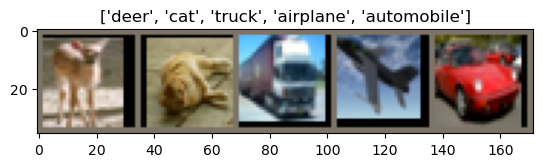

In [8]:
# Printing 5 CIFAR10 train data examples
inputs, classes = next(iter(cifar10_train_loader))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[cifar10_train_set.classes[x] for x in classes[:5]])

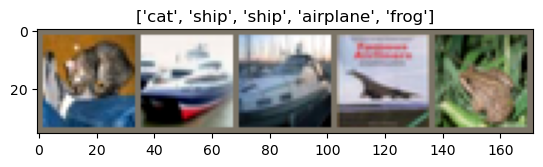

In [9]:
# Printing 5 CIFAR10 test data examples
inputs, classes = next(iter(cifar10_test_loader))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[cifar10_test_set.classes[x] for x in classes[:5]])

# RESNET18 MODEL

In [10]:
'''
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, init_channels=64):
        super(ResNet, self).__init__()
        self.in_planes = init_channels
        
        channels = init_channels
        self.conv1 = nn.Conv2d(3, channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.layer1 = self._make_layer(block, channels, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*channels, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*channels, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*channels, num_blocks[3], stride=2)
        self.linear = nn.Linear(8*channels*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(k=64):
    return ResNet(BasicBlock, [2, 2, 2, 2], init_channels=k)

In [11]:
def get_resnet18_prediction(outputs):
  return torch.max(outputs, 1)[1]

# Learning Functions

In [12]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    
    running_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

In [13]:
def test(model, get_prediction, test_loader):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():            
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predicted = get_prediction(outputs)
            
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    error = 1.0 - (float(correct) / float(total))
    
    return error

In [14]:
def learn(train_loss_list, train_error_list, test_error_list, model, optimizer, criterion, get_prediction, train_loader, test_loader, width, epochs=4000):
    epoch = 0
    for epoch in tqdm(range(epochs), f'Epochs'):
        
        train(model, optimizer, criterion, train_loader)
        train_error = test(model, get_prediction, train_loader)
        test_error = test(model, get_prediction, test_loader)
        
        train_error_list.append(train_error)
        test_error_list.append(test_error)
        
        if epoch % 50 == 0 or epoch == (epochs - 1):
            torch.save(resnet18.state_dict(), f'./Width_Output/{width}_width_{int(NOISE_RATIO*100)}_noise_model_state_dict.pt')
            torch.save(train_error_list, f'./Width_Output/{width}_width_{int(NOISE_RATIO*100)}_noise_train_error_list.pt')
            torch.save(test_error_list, f'./Width_Output/{width}_width_{int(NOISE_RATIO*100)}_noise_test_error_list.pt')

# Running

In [ ]:
for i in range(57,65):
    print(f'Width: {i}')
    resnet18 = ResNet18(k=i).to(torch.device('cuda'))
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    learn([], [], [], resnet18, optimizer, criterion, get_resnet18_prediction, cifar10_train_loader, cifar10_test_loader, i, epochs=1000)

Width: 57


Epochs:   1%|          | 8/1000 [03:25<7:00:14, 25.42s/it]